<a href="https://colab.research.google.com/github/sahin-arslan/VeriMadenciligi/blob/main/OgrenciBasariTahminleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from IPython import get_ipython
from IPython.display import display

!pip install optuna
import optuna #
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error



## 1. Veri setini yükleme ve hazırlama


In [5]:
data = pd.read_csv("StudentDataSets.csv")  # Veri setimizi yüklüyoruz pandas'ı kullanarak

# GPA Dışındaki sütunlarıda x değişkenine atıyoruz.
# Hedef değişken olarak GPA'yı set ederek y değişkenine atıyoruz.
X = data.drop(columns=["GPA"])  # Hedef sütun hariç tüm sütunlar
y = data["GPA"]  # Hedef sütun

# Eğer kategorik veriler varsa, dummies ile dönüştürüyoruz.
X = pd.get_dummies(X, drop_first=True)

# Eğitim ve test seti oluşturuyoruz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 2. Hiperparametre optimizasyonu için bir hedef fonksiyonu tanımlayın

In [6]:

def objective(trial):
    # Optuna'nın optimize etmesi için hiperparametrelerimiz
    n_estimators = trial.suggest_int("n_estimators", 10, 200)  # Ağaç sayısı
    max_depth = trial.suggest_int("max_depth", 2, 32)  # Ağaç derinliği
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  # Minimum dal bölme
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)  # Minimum yaprak boyutu

    # Random Forest modelini oluşturuyoruz
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Çapraz doğrulama ile model performansını değerlendiriyoruz
    score = -cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()
    return score



## 3. Optuna çalıştırarak en iyi parametreleri bulma

In [7]:

study = optuna.create_study(direction="maximize")  #Accuracy'yi maksimize etmeye çalışıyoruz
study.optimize(objective, n_trials=100)  #100 farkı deneme yaparak en iyi sonuça uşalmaya çalışıyoruz

# En iyi hiperparametreleri alıyoruz.
best_params = study.best_params
print("En iyi hiperparametreler:", best_params)


[I 2025-01-25 18:57:30,653] A new study created in memory with name: no-name-e9e76864-6e89-422b-a25c-96d8db0248c2
[I 2025-01-25 18:57:43,791] Trial 0 finished with value: 0.6020751942442814 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.6020751942442814.
[I 2025-01-25 18:58:05,485] Trial 1 finished with value: 0.60927268486675 and parameters: {'n_estimators': 154, 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.60927268486675.
[I 2025-01-25 18:58:13,221] Trial 2 finished with value: 0.6175494568221932 and parameters: {'n_estimators': 55, 'max_depth': 26, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.6175494568221932.
[I 2025-01-25 18:58:34,909] Trial 3 finished with value: 0.6131008197423805 and parameters: {'n_estimators': 141, 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 3}. Best is trial 2 with value

En iyi hiperparametreler: {'n_estimators': 10, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}


## 4. En iyi parametrelerle modeli yeniden eğitme - Changed to Regressor

In [8]:

final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=19, n_estimators=10, random_state=42)

## 5. Modeli test seti üzerinde değerlendirme - Changed metric to MSE

In [9]:
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test seti ortalama kare hatası:", mse)

Test seti ortalama kare hatası: 0.6519442951237608


## Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması (Scatter Plot)

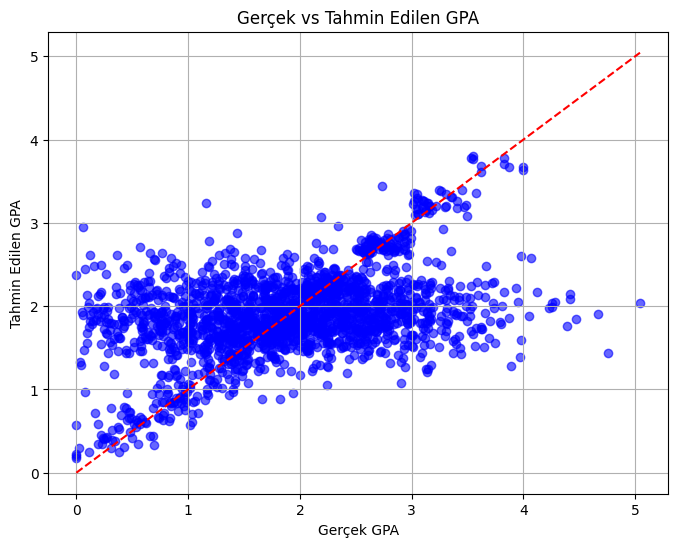

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Gerçek vs Tahmin Edilen GPA")
plt.xlabel("Gerçek GPA")
plt.ylabel("Tahmin Edilen GPA")
plt.grid(True)
plt.show()


## Hataların Dağılımı (Residual Plot)

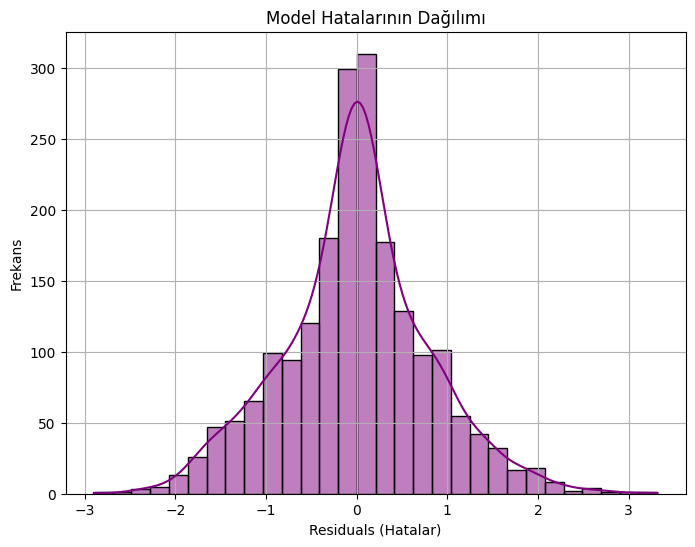

In [11]:
# Modelin hataları
residuals = y_test - y_pred

# Hataların dağılımını gösteren histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title("Model Hatalarının Dağılımı")
plt.xlabel("Residuals (Hatalar)")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()
